# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

In [2]:
import pandas as pd
import numpy as np
from scipy import stats

In [3]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [4]:
# number of callbacks for white-sounding names
sum(data[data.race=='w'].call)

235.0

In [5]:
# number of callbacks for black-sounding names
sum(data[data.race=='b'].call)

157.0

In [6]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


<div class="span5 alert alert-success">
<p>Your answers to Q1 and Q2 here</p>
</div>

### 1. What test is appropriate for this problem? Does CLT apply?
### 2. What are the null and alternate hypotheses?

1. The appropriate test for this problem is null hypothesis testing, namely using either bootstrap replicates or frequentist statistics to test the hypothesis if there is no significant difference between the black and white call rates of resumes. The Central Limit Theorem does apply here because 1) it meets the sample size assumption. CLT states that the sampling distribution of the sample means approaches a normal distribution as the sample size gets larger — no matter what the shape of the population distribution. This fact holds especially true for sample sizes over 30. The sample size is 4879 here, large enough for the CLT to apply. 2). The sampling is random and independent. 

2. The null nypothesis is, there is no significant difference between the the resume call rate of with black and white sounding names. The alternate hypothesis is, there is a significant difference between the the resume call rate of with black and white sounding names.

In [7]:
w = data[data.race=='w']
b = data[data.race=='b']

### 3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.

#### The assumption of this hypothesis test is that all other criteria are randomly distributed in this dataset, and the black and white names are also randomly assigned to these resumes.

#### 1) Using bootstraping approach

In [8]:
# numbers of black and white sounding names
n_b = len(b)
n_w = len(w)
# numbers of calls 
c_b = sum(data[data.race=='b'].call)
c_w = sum(data[data.race=='w'].call)
# Call rate
cr_b = c_b/n_b
cr_w = c_w/n_w
print('numbers of black and white names are', n_b, 'and', n_w)
print('numbers of calls from black and white names are', c_b, 'and', c_w)
print('the call rates from resumes of black and white names are', cr_b, 'and', cr_w)

numbers of black and white names are 2435 and 2435
numbers of calls from black and white names are 157.0 and 235.0
the call rates from resumes of black and white names are 0.06447638603696099 and 0.09650924024640657


In [9]:
call_array = np.array(data.call)

In [10]:
# Under the null hypothesis, there is no difference between the the resume call rate of with black and white sounding names. 
# And the difference in the call rates happens purely by chance .
# The difference between the call rates
diff = cr_w - cr_b
diff

0.032032854209445585

In [11]:
# create bootstrap samples
bs_diff = np.empty(10000)
for i in range(10000):
    bs_sample_b = np.random.choice(call_array, size=n_b)
    # bs_b is the call rate of resume from black sounding names, bs_w is the call rate for the 'white'
    bs_b = np.sum(bs_sample_b)/n_b
    bs_w = (np.sum(call_array)-np.sum(bs_sample_b))/n_w
    bs_diff[i] = bs_w - bs_b

In [12]:
import matplotlib.pyplot as plt

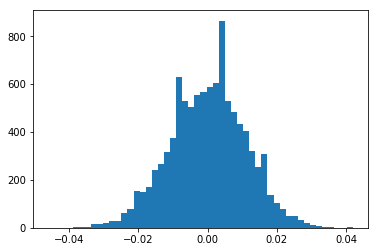

In [13]:
plt.hist(bs_diff, bins=50)
plt.show()

In [14]:
# p-value
p = np.sum(bs_diff >= diff) / 10000
print('p-value is', p)

p-value is 0.0017


The p-value is so low that the difference in callback rate is not caused by pure chance.

In [28]:
# Set the significance level alpha = 0.05, the 2.5% to 97.5% percentile is
# Shifted the bootstraping samples to make the confidence interval centered around the original mean of difference.
# 1) Use the 2.5-97.5% percentile method
bs_diff_shifted = bs_diff - np.mean(bs_diff) + diff
conf_int = np.percentile(bs_diff_shifted, [2.5, 97.5])
print('The 95% confidence interval is', conf_int)

The 95% confidence interval is [0.00972493 0.05325676]


In [29]:
# 2) Calculate the real 95% confidence interval
bs_diff_mean = np.mean(bs_diff)
bs_diff_std = np.std(bs_diff)
stats.norm.interval(0.95, loc=diff, scale=bs_diff_std)

(0.010502643623267843, 0.053563064795623325)

The 95% confidence interval calculated used two methods are similar.

In [17]:
# Margin of Error for 95% confidence interval corresponds to a z-value of 1.96
1.96*bs_diff_std

0.02153060621611947

#### 2) Using the frequentist statistical approach

In [18]:
# The mean difference of call rates in these two groups (w and b) is normally distributed, and the standard deviation std_diff 
# is given by std_diff = sqrt(std_b^2/n_b+std_w^2/n_w)
std_b = np.std(np.array(b.call))
std_w = np.std(np.array(w.call))
std_diff = np.sqrt(std_b**2/n_b+std_w**2/n_w)
print('The standard deviations of the call rate in and black and white groups are', std_b, 'and', std_w)
print('The standard deviation of the difference of these two groups is', std_diff)

The standard deviations of the call rate in and black and white groups are 0.24559963 and 0.29528835
The standard deviation of the difference of these two groups is 0.007783370603907358


In [19]:
# Calculate the z-score of the difference here 
# The theoretical difference of the two groups should be 0 if the hypothesis that there is no difference between call rates is true.
diff_theo = 0
z = (diff-diff_theo)/std_diff
print('The z-score is', z)

The z-score is 4.115550426619112


In [20]:
# one sided p-value using stats.norm.sf(abs(z))
p_value = stats.norm.sf(abs(z)) 
print('The p-value is', p_value)

The p-value is 1.9312826800541776e-05


In [21]:
# two sided p-value using stats.norm.cdf(-z)*2 
# two sided p-value is the right one to use here if the alternative hypothesis that the callback success for white is significantly
# higher than that of the black, or the call back success for 'black' is significantly higher than that of the 'white'.
p_value2 = stats.norm.cdf(-z) * 2
p_value2

3.862565360108355e-05

In [30]:
# The 95% confidence interval correspond to a significance level of 0.05
conf_int2 = stats.norm.interval(0.95, loc=diff, scale=std_diff)
print('The 95% confidence interval of the difference of call rates of black and white is', conf_int2)

The 95% confidence interval of the difference of call rates of black and white is (0.016777728147459394, 0.04728798027143177)


The theoretical difference 0 is outside the 95% confidence interval. So the difference does not happen by pure chance.

<div class="span5 alert alert-success">
<p> Your answers to Q4 and Q5 here </p>
</div>

### 4. Write a story describing the statistical significance in the context or the original problem.

Assuming other criteria are the same or randomly distributed among the groups with black or white sounding names, both approaches show that the p-value of getting such a big difference in the black and white resume call rates is so low that the hypothesis there is no significant difference in call rates is faulse. The difference in the call rates did not happen purely by chance, and it is associated with the black or white sounding names.

### 5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

This analysis does not necessarily mean race/name is the most important factor in callback success because there are so many other criteria out there that could affect the callback success. 
I would analyze a few other factors and evaluation the relationship between them and the callback success.

In [23]:
from IPython.display import display

In [24]:
callback = data.groupby('call').mean()
pd.options.display.max_columns = None
display(callback)

,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,occupbroad,workinschool,email,computerskills,specialskills,h,l,adid,fracblack,fracwhite,lmedhhinc,fracdropout,fraccolp,linc,col,eoe,parent_sales,parent_emp,branch_sales,branch_emp,fed,fracblack_empzip,fracwhite_empzip,lmedhhinc_empzip,fracdropout_empzip,fraccolp_empzip,linc_empzip,manager,supervisor,secretary,offsupport,salesrep,retailsales,req,expreq,comreq,educreq,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind
call,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,3.619696,3.660563,7.751228,0.048013,0.410451,0.098928,0.437472,213.860875,3.460697,0.563644,0.475435,0.823805,0.313310,0.498437,0.501563,644.512939,0.313002,0.539347,10.142312,0.187040,0.211467,9.542634,0.720634,0.290755,580.995850,2191.904541,203.602310,768.117249,0.113438,0.078705,0.845355,10.661489,0.101429,0.332549,10.030473,0.154310,0.078160,0.332291,0.114113,0.153417,0.167709,0.792318,0.438142,0.124609,0.109870,0.440822,0.075257,0.085306,0.028584,0.085753,0.216615,0.266860,0.15096,0.165922
1.0,3.604592,3.670918,8.890306,0.107143,0.423469,0.076531,0.568878,235.936224,3.719388,0.512755,0.522959,0.783163,0.505102,0.545918,0.454082,734.767883,0.285926,0.581963,10.203009,0.169992,0.240760,9.644422,0.706633,0.295918,677.433594,3557.262451,105.912766,597.571411,0.130802,0.084698,0.820905,10.572091,0.105458,0.352861,10.046303,0.127551,0.066327,0.339286,0.170918,0.125000,0.170918,0.729592,0.403061,0.127551,0.071429,0.395408,0.043367,0.056122,0.051020,0.076531,0.183673,0.278061,0.19898,0.155612


So as showed above, other important factors that might affect the callback success include 'yearsexp', 'honors', 'empholes', 'occupspecific', 'occupbroad', 'email', 'specialskills', 'h', 'adid', 'fraccoip', 'parent_sales', etc. Then I would analyze if there is any significant difference in the race groups, 'b' and 'w'.

In [25]:
race_df = data.groupby('race').mean()
display(race_df)

,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,occupbroad,workinschool,email,computerskills,specialskills,h,l,call,adid,fracblack,fracwhite,lmedhhinc,fracdropout,fraccolp,linc,col,eoe,parent_sales,parent_emp,branch_sales,branch_emp,fed,fracblack_empzip,fracwhite_empzip,lmedhhinc_empzip,fracdropout_empzip,fraccolp_empzip,linc_empzip,manager,supervisor,secretary,offsupport,salesrep,retailsales,req,expreq,comreq,educreq,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind
race,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
b,3.616016,3.658316,7.829569,0.051335,0.414374,0.101848,0.445996,216.744969,3.487885,0.560986,0.479671,0.832444,0.327310,0.502259,0.497741,0.064476,651.777832,0.313214,0.540329,10.143023,0.185319,0.212640,9.547022,0.722793,0.29117,587.686462,2287.05127,196.050659,755.416992,0.114765,0.079096,0.843762,10.65568,0.101692,0.333873,10.031505,0.151951,0.077207,0.333060,0.118686,0.151129,0.167967,0.787269,0.435318,0.124846,0.106776,0.437372,0.07269,0.082957,0.03039,0.08501,0.213963,0.267762,0.154825,0.165092
w,3.620945,3.664476,7.856263,0.054209,0.408624,0.092402,0.450103,214.530595,3.475154,0.558111,0.478850,0.808624,0.330185,0.502259,0.497741,0.096509,651.777832,0.308439,0.545211,10.151353,0.186026,0.214998,9.554592,0.716222,0.29117,587.686462,2287.05127,196.050659,755.416992,0.114765,0.079096,0.843762,10.65568,0.101692,0.333873,10.031505,0.152361,0.077207,0.332649,0.118686,0.151129,0.167967,0.787269,0.435318,0.124846,0.106776,0.436961,0.07269,0.082957,0.03039,0.08501,0.213963,0.267762,0.154825,0.165092


### There is no significant difference in all other factors in the two race groups. The conclusion is along with many other factors, race also plays a significant factor in callback success in this case.